### 라이브러리 선언

In [1]:
# 데이터 조작 및 숫자연산
import pandas as pd
import numpy as np
# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 분석모델
from sklearn.tree import DecisionTreeRegressor

In [3]:
# 분석평가 지표
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 데이터 불러오기

In [4]:
selloutData = pd.read_csv("../dataset/feature_regression_example.csv")

### EDA (Exploratory Data Analysis)

In [5]:
selloutData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   REGIONID      105 non-null    object 
 1   PRODUCTGROUP  105 non-null    object 
 2   PRODUCT       105 non-null    object 
 3   ITEM          105 non-null    object 
 4   YEARWEEK      105 non-null    int64  
 5   YEAR          105 non-null    int64  
 6   WEEK          105 non-null    int64  
 7   QTY           105 non-null    int64  
 8   HOLIDAY       105 non-null    object 
 9   HCLUS         105 non-null    int64  
 10  PROMOTION     105 non-null    object 
 11  PRO_PERCENT   105 non-null    float64
dtypes: float64(1), int64(5), object(6)
memory usage: 10.0+ KB


In [6]:
selloutData.shape

(105, 12)

In [7]:
# 데이터 통계값 확인
selloutData.describe()

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,201576.276190,2015.495238,26.752381,1210.238095,2.742857,0.205780
std,52.254278,0.502375,15.229514,820.097819,1.587382,0.128636
min,201501.000000,2015.000000,1.000000,15.000000,0.000000,0.000000
25%,201527.000000,2015.000000,14.000000,542.000000,1.000000,0.208155
50%,201553.000000,2015.000000,27.000000,1139.000000,4.000000,0.209442
75%,201626.000000,2016.000000,40.000000,1753.000000,4.000000,0.280258
max,201652.000000,2016.000000,53.000000,4035.000000,4.000000,0.421888


C:\Users\kopo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='QTY', ylabel='Density'>

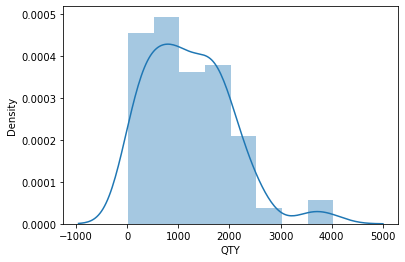

In [8]:
sns.distplot(selloutData.QTY)

### 1. 타입 통합/특성 숫자컬럼 추가

In [9]:
# 컬럼 타입 매핑
strColumns = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM","HOLIDAY","PROMOTION"]
intColumns = ["YEARWEEK", "YEAR", "WEEK", "HCLUS"]
floatColumns = ["QTY","PRO_PERCENT"]

In [10]:
# str 컬럼 정보 매핑 (테이블정의서와 동일하게)
for i in range(0, len(strColumns)):
    selloutData[strColumns[i]] = selloutData[strColumns[i]].astype(str)

In [11]:
# int 컬럼 정보 매핑 (테이블정의서와 동일하게)
for i in range(0, len(intColumns)):
    selloutData[intColumns[i]] = selloutData[intColumns[i]].astype(int)

In [12]:
# float 컬럼 정보 매핑 (테이블정의서와 동일하게)
for i in range(0, len(floatColumns)):
    selloutData[floatColumns[i]] = selloutData[floatColumns[i]].astype(float)

In [13]:
selloutData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int32
YEAR              int32
WEEK              int32
QTY             float64
HOLIDAY          object
HCLUS             int32
PROMOTION        object
PRO_PERCENT     float64
dtype: object

In [14]:
selloutData.PROMOTION.drop_duplicates()

0    Y
9    N
Name: PROMOTION, dtype: object

In [15]:
ynMap = {"Y":1, "N":0}

In [16]:
selloutData["PROMOTION_MAP"] = np.where(selloutData.PROMOTION == "Y", 1, 0)

In [17]:
selloutData["PROMOTION_MAP"] = selloutData.PROMOTION.map(ynMap)
selloutData["HOLIDAY_MAP"] = selloutData.HOLIDAY.map(ynMap)
selloutData.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTION_MAP,HOLIDAY_MAP
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225.0,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968.0,N,4,Y,0.209442,1,0


### 2. 특성 선정 / 데이터 분리

### 2-1. 특성 선정

In [18]:
selloutData.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTION_MAP,HOLIDAY_MAP
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225.0,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968.0,N,4,Y,0.209442,1,0


In [19]:
corrStd = 0.5

In [20]:
corrDf = selloutData.corr()

In [21]:
label=["QTY"]

In [22]:
features = \
    list( corrDf.loc[ (abs( corrDf.QTY ) > corrStd ) & (corrDf.QTY != 1 ) ].index )

### 2-2. 데이터 분리

In [23]:
sortKey = ["ITEM","YEARWEEK"]

In [24]:
sortedData = selloutData.sort_values(sortKey)
sortedData.shape

(105, 14)

In [25]:
# 전체 데이터 row 의 80% 시점의 index값 정의
stdIndex = int( list( sortedData.shape ) [0] * 0.8 )

In [26]:
stdYearWeek = sortedData.loc[stdIndex].YEARWEEK

In [27]:
stdYearWeek

201632

In [28]:
trainingDataFeatures = sortedData.loc[ sortedData.YEARWEEK < stdYearWeek, features]
trainingDataLabel = sortedData.loc[ sortedData.YEARWEEK < stdYearWeek, label]
testDataFeatures = sortedData.loc[ sortedData.YEARWEEK >= stdYearWeek, features]
testDataLabel = sortedData.loc[ sortedData.YEARWEEK >= stdYearWeek, label]

In [29]:
testDataAll = sortedData.loc[ sortedData.YEARWEEK >= stdYearWeek]

In [30]:
print(trainingDataFeatures.shape)
print(trainingDataLabel.shape)
print(testDataFeatures.shape)
print(testDataLabel.shape)

(84, 4)
(84, 1)
(21, 4)
(21, 1)


### 3. 모델 적용

In [31]:
from sklearn import tree

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
DecisionTreeRegressor(random_state=11)

DecisionTreeRegressor(random_state=11)

In [34]:
modelMethod = DecisionTreeRegressor(random_state=1)

In [35]:
modelCoeff = modelMethod.fit(X=trainingDataFeatures, y=trainingDataLabel)

In [36]:
modelCoeff

DecisionTreeRegressor(random_state=1)

### 4. 예측

In [37]:
predictValue=modelCoeff.predict(testDataFeatures)

In [38]:
predictValue

array([1578.33333333,  350.71428571, 1434.6       , 1434.6       ,
       1434.6       , 1434.6       , 1434.6       , 1578.33333333,
       1578.33333333, 2620.42857143, 1578.33333333,  350.71428571,
       2193.8       , 2193.8       , 2193.8       , 2193.8       ,
       2193.8       , 2193.8       , 2193.8       , 2193.8       ,
       2193.8       ])

### 5. 데이터 정리

In [39]:
testDataAll.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTION_MAP,HOLIDAY_MAP
84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100.0,N,4,Y,0.280258,1,0
85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43.0,N,4,N,0.000000,0,0


In [40]:
testDataAll["PREDICT_DT"] = predictValue

C:\Users\kopo\AppData\Local\Temp/ipykernel_8696/3972717254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDataAll["PREDICT_DT"] = predictValue


In [41]:
testDataAll["DT_PREDICT"] = predictValue

C:\Users\kopo\AppData\Local\Temp/ipykernel_8696/1912915876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDataAll["DT_PREDICT"] = predictValue


In [42]:
testDataAll.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTION_MAP,HOLIDAY_MAP,PREDICT_DT,DT_PREDICT
84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100.0,N,4,Y,0.280258,1,0,1578.333333,1578.333333
85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43.0,N,4,N,0.000000,0,0,350.714286,350.714286


### 6. 데이터 시각화

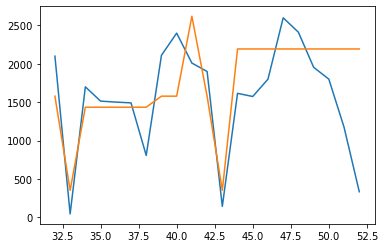

In [43]:
plt.plot(testDataAll.WEEK, testDataAll.QTY)
plt.plot(testDataAll.WEEK, testDataAll.DT_PREDICT)

### [참고] 학습된 coeff 활용 미래데이터 예측하기

In [44]:
features

['HCLUS', 'PRO_PERCENT', 'PROMOTION_MAP', 'HOLIDAY_MAP']

In [45]:
testHCLUS = 4 # 대휴일이 1 소휴일이 1
testPRO_PERCENT = 0.01 #할인율
testPROMOTIONMAP = 0
testHolidayMap = 0

In [46]:
testDf = \
    pd.DataFrame( [[ testHCLUS, testPRO_PERCENT, testPROMOTIONMAP, testHolidayMap]] )

In [47]:
modelCoeff.predict(testDf)

array([350.71428571])

In [48]:
mean_absolute_error( y_true=testDataAll.QTY,
                    y_pred=testDataAll.DT_PREDICT )

483.5106575963719

In [49]:
np.sqrt( mean_squared_error (y_true=testDataAll.QTY,
                             y_pred=testDataAll.DT_PREDICT ))

622.3045269122888